# K Means clustering
This notebook follows closely [Lesson 12](https://github.com/fastai/course22p2/blob/master/nbs/02_meanshift.ipynb) of Practical Deep Learning for Coders. The goal is to implement a clustering algorithm from scratch so that we can truly understand it.

In the lesson notebook, Jeremy implemented the meanshift algorithm. I have decided to implement the k-means algorithm instead as it is commonly used/taught in schools.

In [2]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [3]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [4]:
n_clusters = 6
n_samples = 250

We are going to create 6 clusters, and each cluster has 250 points around it.

In [5]:
# multiply by 2 as there are 2 dimensions
centroids = torch.rand(n_clusters, 2) * 100 - 50

In [6]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [7]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [8]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices) # we want to work in Tensors
data.shape

torch.Size([1500, 2])

Let's write a helper function to plot the data. Each centroid will be marked with X, while each clustering will have an associated color.

In [9]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples: (i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color="k", mew=5)
        ax.plot(*centroid, markersize=5, marker="X", color="m", mew=2)

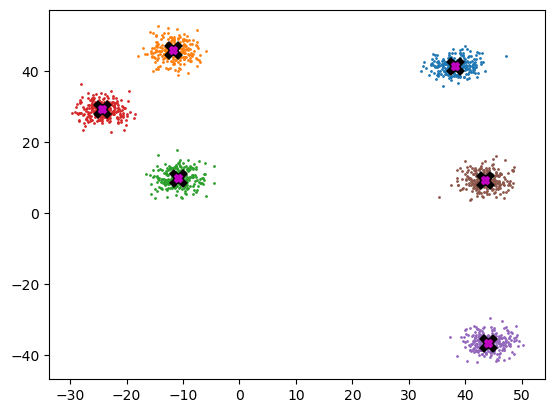

In [10]:
plot_data(centroids, data, n_samples)

## K-means algorithm
K-means is a well-known clustering algorithm. Its pseudo-code works as follows:

Inputs:
- K: number of clusters
- data: set of data points

Algorithm:
1. Initialise `K` centroids randomly by assiging a random data point as a centroid's coordinates.
2. Repeat until convergence:
- Assign each data point to the nearest centroid
- Update centroids using the assigned data points.
- Check for convergence
3. Output final clusters and centroids

In [11]:
data

tensor([[37.672, 38.799],
        [37.159, 42.663],
        [41.899, 41.144],
        ...,
        [43.810, 12.131],
        [42.392,  6.767],
        [44.206,  8.116]])

In [41]:
def init_kmeans_centroids(n_clusters):
    random_indices = torch.randperm(data.size(0))[:n_clusters]
    return data[random_indices]

kmeans_centroids = init_kmeans_centroids(n_clusters)

Our next step is to find out how to implement a L2 norm for each data point and each of the centroids so that we can assign them accordingly.

In [13]:
X = data.clone()
x = X[0]
x

tensor([37.672, 38.799])

In [14]:
x.shape, kmeans_centroids.shape

(torch.Size([2]), torch.Size([6, 2]))

In [15]:
x[None,:].shape, kmeans_centroids.shape

(torch.Size([1, 2]), torch.Size([6, 2]))

In [16]:
dist = torch.einsum('ij->i', ((x - kmeans_centroids)**2)).sqrt()
dist

tensor([60.187,  2.266,  5.197, 55.668, 67.276, 60.450])

In [17]:
torch.argmin(dist)

tensor(1)

In [18]:
point_indices = torch.zeros((n_clusters*n_samples), dtype=torch.uint8)
point_indices.shape

torch.Size([1500])

In [19]:
point_indices[0] = torch.argmin(dist)
point_indices[0]

tensor(1, dtype=torch.uint8)

In [20]:
data[point_indices == 2]

tensor([], size=(0, 2))

Ok, now we can start putting these steps together into a single function that expresses a single step in the k-means algorithm.

In [21]:
def one_update(X, kmeans_centroids):
    point_indices = torch.zeros((n_clusters*n_samples), dtype=torch.uint8)
    for i, x in enumerate(X):
        # assign each data point to nearest centroid
        dist = torch.einsum('ij->i', ((x - kmeans_centroids)**2)).sqrt()
        point_indices[i] = torch.argmin(dist)

    # re-calculate new kmeans centroid
    updated_kmeans_centroids = torch.zeros(kmeans_centroids.shape)
    for i in range(n_clusters):
        updated_kmeans_centroids[i] = torch.mean(X[point_indices==i], dim=0)

    return updated_kmeans_centroids

In [22]:
updated_kmeans_centroids = one_update(X, kmeans_centroids)
updated_kmeans_centroids

tensor([[-13.814,   9.371],
        [ 42.504,  10.016],
        [ 39.023,  42.565],
        [ 17.058, -13.684],
        [-26.821,  28.840],
        [-16.341,  39.122]])

I'm not entirely sure if this is working correctly, time it, then plot it to see where the centroids end up at.

In [23]:
def kmeans(X):
    # init centroids
    random_indices = torch.randperm(X.size(0))[:n_clusters]
    kmeans_centroids = X[random_indices]
    init_centroids = kmeans_centroids.clone()

    for i in range(30): # randomly pick 30 steps
        kmeans_centroids = one_update(X, kmeans_centroids)

    return init_centroids, kmeans_centroids

In [24]:
%time init_centroids, final_centroids=kmeans(X)

CPU times: user 821 ms, sys: 3.63 ms, total: 824 ms
Wall time: 655 ms


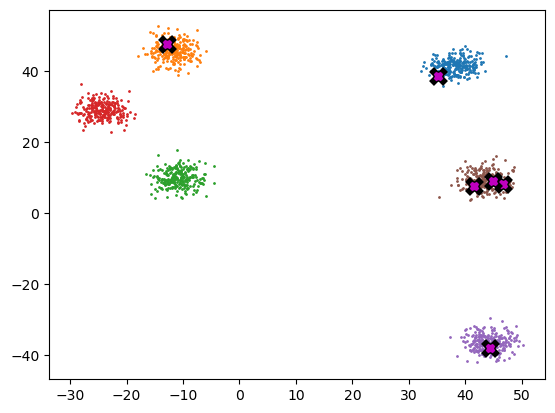

In [25]:
plot_data(init_centroids, data, n_samples)

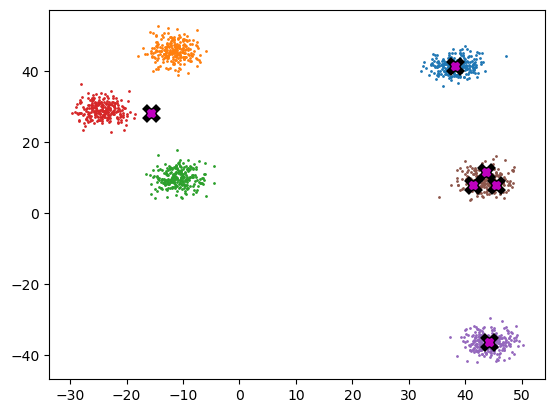

In [26]:
plot_data(final_centroids, data, n_samples)

We see that k-means has indeed converged, albeit not to an optimal solution.

## Animation

In [27]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [28]:
def do_one(d):
    global kmeans_centroids
    if d: kmeans_centroids = one_update(X, kmeans_centroids)
    ax.clear()
    plot_data(kmeans_centroids, X, n_samples, ax=ax)

In [29]:
random_indices = torch.randperm(data.size(0))[:n_clusters]
kmeans_centroids = data[random_indices]

fig, ax = plt.subplots()
ani= FuncAnimation(fig, do_one, frames=30, interval=500)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm
We are going to speed things up, more specifically by batching the distance calculation and assignment to nearest centroid operations.

Currently, we are iterating over each sample 1 by 1. We will batch this to get a speed up.

In [30]:
bs = 8
X = data.clone()
x = X[:bs]
x.shape, X.shape

(torch.Size([8, 2]), torch.Size([1500, 2]))

In [42]:
kmeans_centroids = init_kmeans_centroids(n_clusters)
kmeans_centroids

tensor([[-21.733,  31.137],
        [ 46.665, -36.590],
        [-11.035,  44.924],
        [ 44.519,   9.427],
        [ 44.089,   9.553],
        [ -9.410,  43.989]])

In [35]:
x[:,None].shape

torch.Size([8, 1, 2])

In [33]:
kmeans_centroids[None].shape

torch.Size([1, 6, 2])

In [40]:
def dist_b(x, kmeans_centroids):
    return ((x[:, None] - kmeans_centroids[None])**2).sum(2).sqrt()

In [43]:
dist = dist_b(x, kmeans_centroids)
dist.shape

torch.Size([8, 6])

In [48]:
dist

tensor([[59.896, 75.924, 49.091, 30.159, 29.942, 47.367],
        [60.009, 79.822, 48.247, 34.041, 33.828, 46.588],
        [64.414, 77.880, 53.069, 31.824, 31.667, 51.388],
        [59.931, 79.648, 48.212, 33.875, 33.661, 46.549],
        [65.439, 79.233, 53.792, 33.166, 33.020, 52.135],
        [64.017, 76.186, 53.064, 30.138, 29.976, 51.357],
        [64.204, 81.182, 52.125, 35.140, 34.976, 50.499],
        [62.760, 81.383, 50.629, 35.402, 35.221, 49.005]])

In [49]:
closest_idx = torch.argmin(dist, dim=1)
closest_idx.shape

torch.Size([8])

In [50]:
closest_idx

tensor([4, 4, 4, 4, 4, 4, 4, 4])

In [54]:
def one_update_b(X, kmeans_centroids, bs=bs):
    point_indices = torch.zeros((n_clusters*n_samples), dtype=torch.uint8).cuda()
    n = len(X)
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        # assign each data point to nearest centroid
        dist = dist_b(X[s], kmeans_centroids)
        point_indices[s] = torch.argmin(dist, dim=1)

    # re-calculate new kmeans centroid
    updated_kmeans_centroids = torch.zeros(kmeans_centroids.shape).cuda()
    for i in range(n_clusters):
        updated_kmeans_centroids[i] = torch.mean(X[point_indices==i], dim=0)

    return updated_kmeans_centroids

In [55]:
def kmeans_b(X, bs=256):
    X = X.cuda()
    kmeans_centroids = init_kmeans_centroids(n_clusters).cuda()

    for i in range(30): # randomly pick 30 steps
        kmeans_centroids = one_update_b(X, kmeans_centroids, bs=bs)

    return kmeans_centroids

In [56]:
kmeans_b(X, bs=256)

AssertionError: Torch not compiled with CUDA enabled